# An Identiconizer generator implementation in Python

This small notebook implements a generator of small square icons like the ones in GitHub, as [implemented by identicon.js](https://github.com/stewartlord/identicon.js#identiconjs).

## The function

In [5]:
import random
import numpy as np
from matplotlib.colors import hsv_to_rgb
from PIL import Image as PILImage, ImageDraw as PILImageDraw

In [6]:
%load_ext watermark
%watermark
%watermark -a "Lilian Besson (Naereen)" -p numpy,matplotlib,PIL

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-11-26T12:04:33+01:00

CPython 3.6.3
IPython 6.2.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.13.0-17-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Lilian Besson (Naereen) 

numpy 1.13.3
matplotlib 2.1.0
PIL 4.3.0


## First try

In [8]:
def identicon(hashval=None,
              size=256,
              margin=0.11,
              foreground=(255,0,0,255),
              background=(240,240,240,255),
              saturation=0.7,
              brightness=0.5,
              xsym=True,
    ):
    if hashval is not None:
        if isinstance(hashval, str):
            hashval = abs(hash(hashval))
        random.seed(int(hashval))

    hue = random.random()
    foreground = tuple(np.array(hsv_to_rgb([hue, saturation, brightness]) * 256, dtype=int)) 

    border = int(size * margin)
    ampl = size - 2 * border
    def cropfirst(x):
        return max(border, min(border + x, size - border))
    def cropsecond(x):
        return max(border, min(size - border - x, size - border))

    # make a blank image
    im = PILImage.new('RGBA', (size,size), background)    
    # get a drawing context
    d = PILImageDraw.Draw(im)

    def rect(xy):
        x1, y1, x2, y2 = xy
        r1 = (cropfirst(x1), cropfirst(y1), cropfirst(x2), cropfirst(y2))
        if xsym:
            r2 = (cropsecond(x1), cropfirst(y1), cropsecond(x2), cropfirst(y2))
        else:
            r2 = (cropfirst(x1), cropsecond(y1), cropfirst(x2), cropsecond(y2))
        d.rectangle(r1, fill=foreground)
        d.rectangle(r2, fill=foreground)

    nbrectangle = random.randint(4, 8)
    for i in range(nbrectangle):
        x1, y1 = [random.randint(0, ampl) for _ in range(2)]
        dx, dy = [random.randint(ampl // 8, ampl // 2) for _ in range(2)]
        dirx, diry = [random.choice([+1, -1]) for _ in range(2)]
        rect((x1, y1, x1 + dirx * dx, y1 + diry * dy))
    return im

In [9]:
im = identicon()

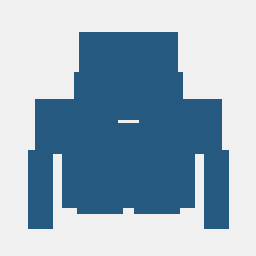

In [10]:
im

## Second try

In [11]:
from itertools import product

In [12]:
def identicon2(hashval=None,
              size=256,
              nbsquares=5,
              margin=0.09,
              foreground=(255,0,0,255),
              background=(240,240,240,255),
              saturation=0.7,
              brightness=0.5,
              xsym=True,
    ):
    if hashval is not None:
        if isinstance(hashval, str):
            hashval = abs(hash(hashval))
        random.seed(int(hashval) % 1<<28)
        np.random.seed(int(hashval) % 1<<28)

    hue = random.random()
    foreground = tuple(np.array(hsv_to_rgb([hue, saturation, brightness]) * 256, dtype=int)) 

    border = int(size * margin)
    ampl = size - 2 * border
    size_square = ampl // nbsquares 

    def cropfirst(x):
        return max(border, min(border + x, size - border))
    def cropsecond(x):
        return max(border, min(size - border - x, size - border))

    # make a blank image
    im = PILImage.new('RGBA', (size,size), background)    
    # get a drawing context
    d = PILImageDraw.Draw(im)

    def rect(xy, xsym=xsym):
        x1, y1, x2, y2 = xy
        r1 = (cropfirst(x1), cropfirst(y1), cropfirst(x2), cropfirst(y2))
        if xsym:
            r2 = (cropsecond(x1), cropfirst(y1), cropsecond(x2), cropfirst(y2))
        else:
            r2 = (cropfirst(x1), cropsecond(y1), cropfirst(x2), cropsecond(y2))
        d.rectangle(r1, fill=foreground)
        d.rectangle(r2, fill=foreground)

    nbrectangle = random.randint(5, nbsquares * (nbsquares // 2 + 1) - 2)
    possible_coordinates = [(x, y) for (x, y) in product(range(nbsquares), range(nbsquares // 2 + 1))]
    for i in np.random.choice(len(possible_coordinates), size=nbrectangle, replace=False):
        y, x = possible_coordinates[i]
        rect((x * size_square, y * size_square, (x+1) * size_square, (y+1) * size_square))
    return im

In [13]:
im = identicon2()

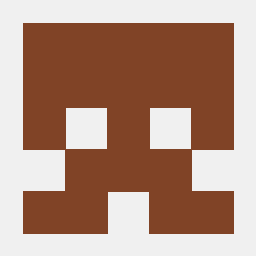

In [14]:
im

## Tests

This second implementation is better: it is deterministic, when given a string or a hash:

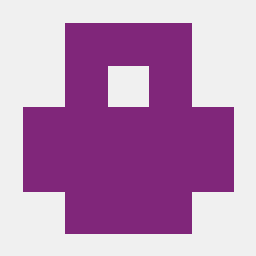

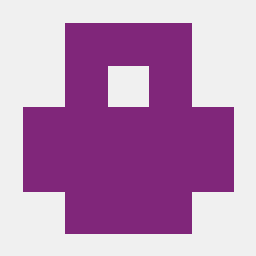

In [15]:
for _ in range(2):
    im = identicon2("Naereen")
    im

And every parameter can be changed and tuned.

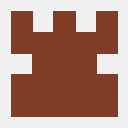

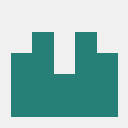

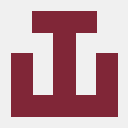

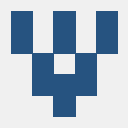

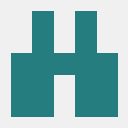

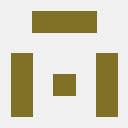

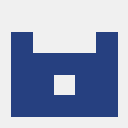

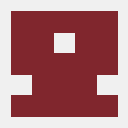

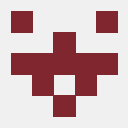

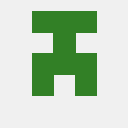

In [16]:
for _ in range(10):
    im = identicon2(size=128)
    im

In [39]:
mylist = [identicon2() for _ in range(10)]

## List of vignettes

Let's use [this technique](https://carreau.github.io/posts/29-JupyterCon-DisplayProtocol.ipynb.html)

In [18]:
import base64

from IPython.display import Image
from IPython.display import HTML

def tag_from_data(data, size='100%'):
    return (
        '''<img
             style="display:inline;
                    width:{1};
                    max-width:400px;
                    padding:10px;
                    margin-top:14px"
             src="data:image/png;base64,{0}"
           />
           ''').format(''.join(base64.encodebytes(data).decode().split('\n')), size)

In [19]:
import io

def im2bytes(im):
    buffer = io.BytesIO()
    im.save(buffer, format="png")
    return buffer.getvalue()


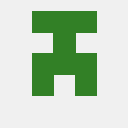

In [20]:
HTML(tag_from_data(im2bytes(im)))

In [21]:
class VignetteList:    
    def __init__(self, *images, size=None):
        self.images = images
        self.size = size
   
    def _repr_html_(self):
        return '<p>'+','.join(tag_from_data(im2bytes(im), self.size)  for im in self.images)+'</p>'


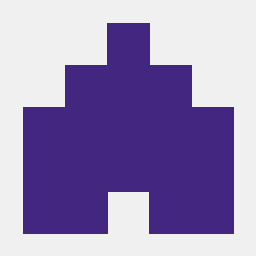
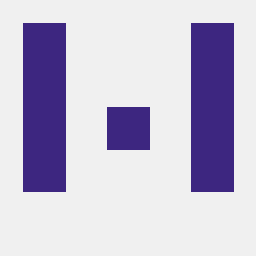
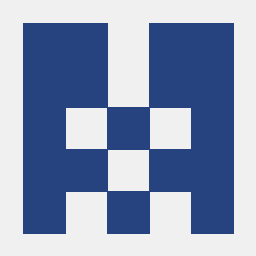
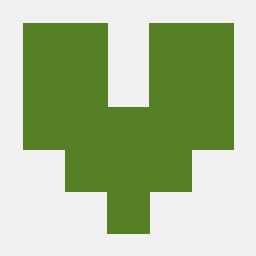
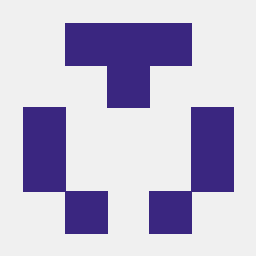
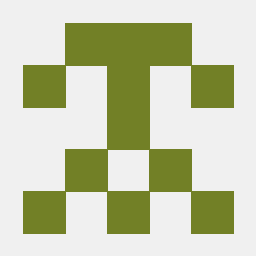
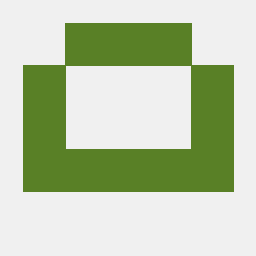
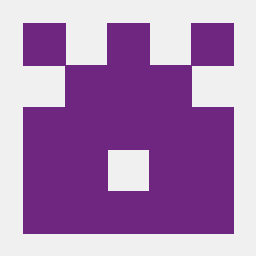
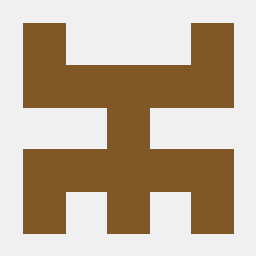
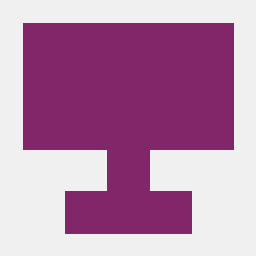

In [41]:
VignetteList(*mylist, size='200px')

In [42]:
def tag_from_data_II(data, size='100%'):
    return '''<img
                    style="
                        display:inline;
                        width:{1};
                        max-width:400px;
                        padding:10px;
                        margin-top:14px"
                    onMouseOver="this.style['box-shadow']='5px 5px 30px 0px rgba(163,163,163,1)'" 
                    onMouseOut="this.style['box-shadow']=''"
                    src="data:image/png;base64,{0}" 
             />'''.format(''.join(base64.encodebytes(data).decode().split('\n')), size)

def html_list_formatter(ll):
    html = get_ipython().display_formatter.formatters['text/html']
    reps = []
    for o in ll:
        if isinstance(o, Image):
            reps.append(tag_from_data_II(o.data, '200px') )
        elif isinstance(im, PILImage.Image):
            reps.append(tag_from_data_II(im2bytes(o), '200px') )
        else:
            h = html(o)
            if h:    
                reps.append(h)
            else:
                reps.append(repr(o)+'')
    
    return '<span>['+','.join(reps)+']</span>'

In [43]:
ipython = get_ipython()
html = ipython.display_formatter.formatters['text/html']
html.for_type(list, html_list_formatter)

<function __main__.html_list_formatter>

[<PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E02E8>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E871908>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E1016D8>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0470>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0710>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0630>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0B00>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0828>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0978>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x7FC51E0E0B70>]
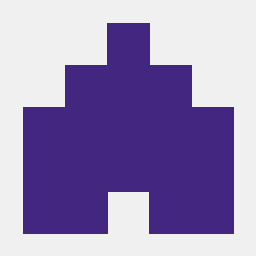
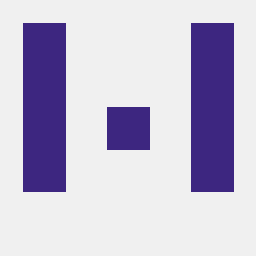
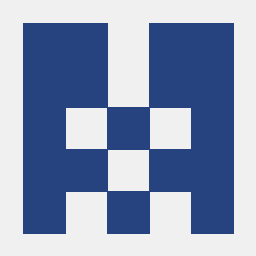
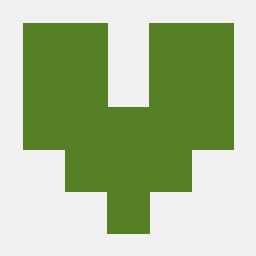
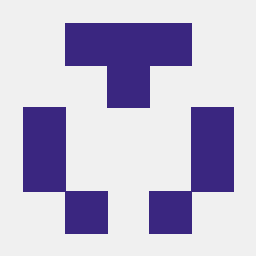
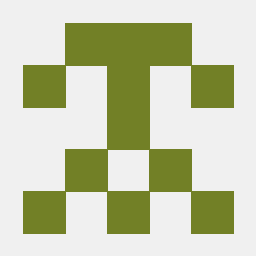
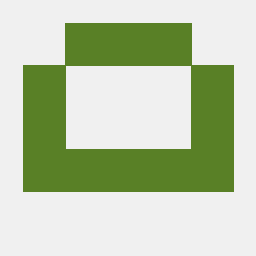
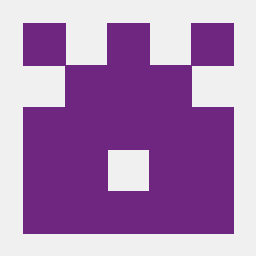
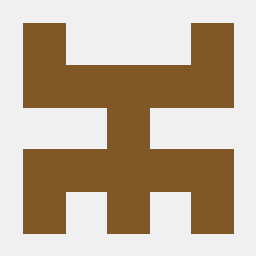
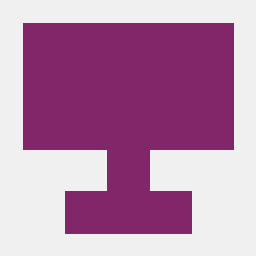

In [44]:
mylist

## Conclusion

> *That's it for today, folks!* [See on my GitHub for more notebooks](https://github.com/Naereen/notebooks)